# <center>ASTR4004/8004 - Neural Networks - Part 5</center>

This notebook builds a Generative Adversarial Network to generate handwritten digits.

We will train the network using handwritten digits from the Modified National Institute of Standards and Technology database (i.e., [MNIST dataset](http://yann.lecun.com/exdb/mnist/)), and construct the following architecture for our network

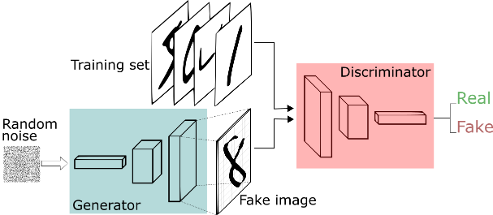

## Useful packages

In [1]:
# Let's work within our working directory, e.g., where MNIST data is stored
import os
os.chdir('/home/563/yq5547/notebooks/ASTR4004')

# We need numpy to handle data and array
import numpy as np

# We need matplotlib.pyplot to make plots
import matplotlib.pyplot as plt

# tensorflow and its keras API provide a NN framework
import tensorflow as tf
# Set the number of threads for intra and inter operations
tf.config.threading.set_intra_op_parallelism_threads(13)  # Set to your desired number
tf.config.threading.set_inter_op_parallelism_threads(13)

from tensorflow.keras import layers, models, optimizers, Model

# set hyperparameters at the beginning
l_rate = 1e-4
Nepoch = 100
batch_size = 64

2024-10-24 17:45:53.203860: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 17:45:53.206830: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:45:53.243013: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 17:45:53.245460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 17:45:55.908704: W tensorflow/compiler/tf2t

## Dataset preparation
MNIST contains 70,000 images of handwritten digits, in greyscale with pixel-values from 0 to 255. Let us first load the data. I have store them in two seperated numpy files. But we only need the images here. Label is not needed.

In [2]:
# load data
images = np.load('./MNIST_images.npy', allow_pickle=True)

# it is normally a good practice to rescale the training data into [0, 1] or [-1, 1]
images = (images - np.min(images)) / (np.max(images) - np.min(images))

# flatten images into 1D array
x = images.reshape([len(images), -1])

### Let's divide the sample into training (90%) and test (10%) 

In [3]:
train_size = int(0.9 * len(x)) # tensorflow can split some from training set for validation
test_size = len(x) - train_size

x_train, x_test = x[:train_size], x[test_size:]
images_test = images[test_size:]

print("Training data: {}".format(x_train.shape))
print("Test data: {}".format(x_test.shape))

Training data: (63000, 784)
Test data: (63000, 784)


### It is often a good practice to reshuffle the training set to get rid of any existing pattern in the data

In [4]:
shuffle_index = np.random.permutation(train_size)
x_train = x_train[shuffle_index]
shuffle_index = np.random.permutation(test_size)
x_test = x_test[shuffle_index]
images_test = images_test[shuffle_index]

## Network definition

### Generator

In [5]:
z_dim = 100
generator = models.Sequential([
    layers.Input(shape=(z_dim,)), # Input layer
    
    layers.Dense(512),            # First Dense layer
    layers.LeakyReLU(0.2),        # LeakyReLU activation
    layers.BatchNormalization(),  # Batch Normalization
    
    layers.Dense(256),            # Second Dense layer
    layers.LeakyReLU(0.2),        # LeakyReLU activation
    layers.BatchNormalization(),  # Batch Normalization
    
    layers.Dense(128),            # Third Dense layer
    layers.LeakyReLU(0.2),        # LeakyReLU activation
    layers.BatchNormalization(),  # Batch Normalization

    layers.Dense(x_train.shape[1], activation='tanh'),  # Output layer
])

2024-10-24 17:46:40.341942: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Use the (untrained) generator to create an image.

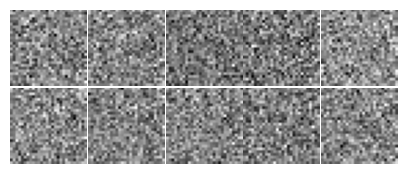

In [6]:
# Visualize generated images
noise = tf.random.normal([10, 100])
generated_images = generator(noise, training=False)
plt.figure(figsize=(5, 2))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow((generated_images[i].numpy().reshape([28,28]) + 1) / 2, cmap='gray')  # Scale to [0, 1]
    plt.axis('off')
plt.subplots_adjust(wspace=0.02,hspace=0.02)

### Discriminator

In [7]:
discriminator = models.Sequential([
    layers.Input(shape=(x_train.shape[1],)),   # Input layer

    layers.Dense(256),                         # First Dense layer
    layers.LeakyReLU(0.2),                     # LeakyReLU activation
    layers.BatchNormalization(),               # Batch Normalization

    layers.Dense(128),                         # Second Dense layer
    layers.LeakyReLU(0.2),                     # LeakyReLU activation
    layers.BatchNormalization(),               # Batch Normalization

    layers.Dense(64),                          # Third Dense layer
    layers.LeakyReLU(0.2),                     # LeakyReLU activation
    
    layers.Dense(1),                          
])

Use the (untrained) discriminator to classify the generated and real images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [8]:
print(discriminator(generated_images)), print(discriminator(x_test[:10]))

tf.Tensor(
[[ 0.09439524]
 [ 0.00141938]
 [-0.04489942]
 [-0.205663  ]
 [-0.08026891]
 [-0.00445106]
 [ 0.0776922 ]
 [ 0.02290178]
 [-0.01912713]
 [ 0.00500032]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[0.2943172 ]
 [0.3891226 ]
 [0.16741055]
 [0.7543659 ]
 [0.56184953]
 [0.28426275]
 [0.32379186]
 [0.43020707]
 [0.22104368]
 [0.15129992]], shape=(10, 1), dtype=float32)


(None, None)

## Loss functions

In [9]:
# Loss function
BCE = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### discriminator loss
The binary cross entropy loss function compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = BCE(tf.ones_like(real_output), real_output)
    fake_loss = BCE(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### generator loss
The generator aims to trick the discriminator. Therefore, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Therefore, the binary cross entropy loss function here compares the discriminators decisions on the generated images to an array of 1s.

In [11]:
def generator_loss(fake_output):
    return BCE(tf.ones_like(fake_output), fake_output)

## Optimizers

In [12]:
# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(l_rate)
discriminator_optimizer = tf.keras.optimizers.Adam(l_rate)

## Network training

Epoch 1/100, Loss: 1.67(G), 0.50(D)
Epoch 11/100, Loss: 3.63(G), 0.20(D)
Epoch 21/100, Loss: 4.36(G), 0.32(D)
Epoch 31/100, Loss: 4.61(G), 0.14(D)
Epoch 41/100, Loss: 3.94(G), 0.22(D)
Epoch 51/100, Loss: 4.30(G), 0.15(D)
Epoch 61/100, Loss: 4.82(G), 0.14(D)
Epoch 71/100, Loss: 4.16(G), 0.41(D)
Epoch 81/100, Loss: 4.66(G), 0.26(D)
Epoch 91/100, Loss: 5.81(G), 0.14(D)


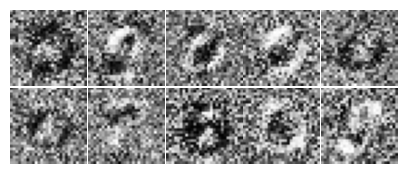

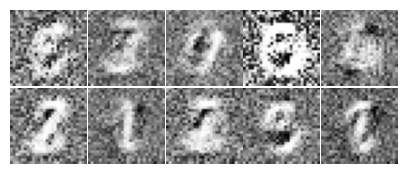

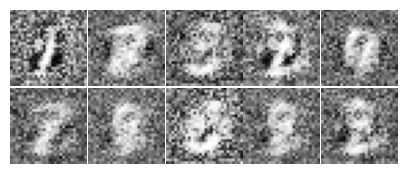

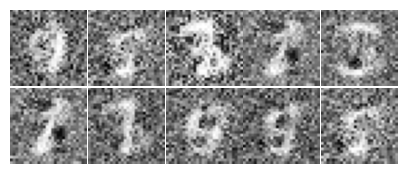

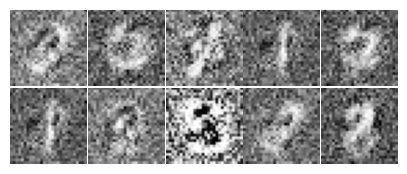

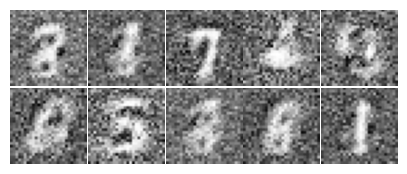

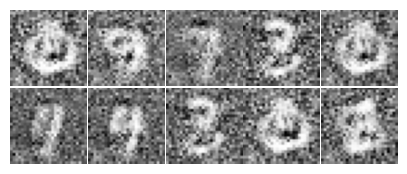

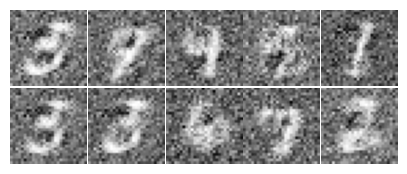

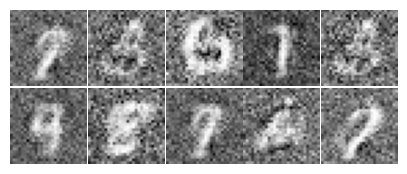

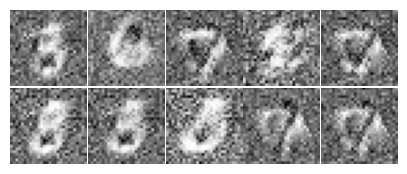

In [13]:
generator_losses = np.zeros(Nepoch)
discriminator_losses = np.zeros(Nepoch)
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

for epoch in range(Nepoch):
    
    for real_images in train_dataset:
        noise = tf.random.normal([batch_size, z_dim])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = generator(noise, training=True)
    
            real_output = discriminator(real_images, training=True)
            fake_output = discriminator(generated_images, training=True)
    
            gen_loss  = generator_loss(fake_output)
            disc_loss = discriminator_loss(real_output, fake_output)
    
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    generator_losses[epoch] = gen_loss.numpy()
    discriminator_losses[epoch] = disc_loss.numpy()

    # Visualize generated images to see the training progress
    if epoch%10 == 0:    
        print(f'Epoch {epoch+1}/{Nepoch}, Loss: {generator_losses[epoch]:.2f}(G), {discriminator_losses[epoch]:.2f}(D)')
        
        noise = tf.random.normal([10, 100])
        generated_images = generator(noise, training=False)
        plt.figure(figsize=(5, 2))
        for i in range(10):
            plt.subplot(2, 5, i + 1)
            plt.imshow((generated_images[i].numpy().reshape([28,28]) + 1) / 2, cmap='gray')  # Scale to [0, 1]
            plt.axis('off')
        plt.subplots_adjust(wspace=0.02,hspace=0.02)

The quality of the images seems to be improving. But we can see that the generator is suffering when we look more closely at its loss

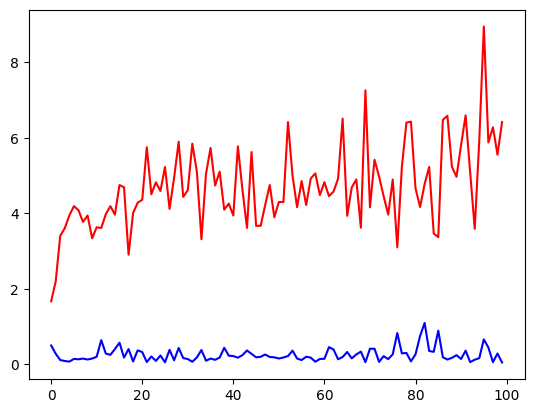

In [14]:
## plot the loss
plt.plot(generator_losses, 'r-')
plt.plot(discriminator_losses, 'b-')

The generator cannot compete against the discriminator when the discriminator becomes too strong, making it difficult for the generator to improve. What to do:
* Adjust the Learning Rates - If the discriminator is learning too quickly, it might overpower the generator. Lowering the learning rate can give the generator a chance to improve. Vice versa, Increasing the learning rate of the generator can help it catch up when the discriminator is too strong.
* Label smoothing is a technique where the real labels for the discriminator are slightly altered from 1 to a value slightly less than 1 (e.g., 0.9). This prevents the discriminator from becoming too confident and overpowering the generator.
* Adding some noise to the labels of the discriminator can help prevent it from becoming too strong. This can be done by flipping the labels of some real and fake samples randomly during training.
* Update Generator more often
* Change the architeture including the activation functions and loss functions.

<font color='red'> give a try of these methods to improve the GAN</font>